<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/HippoWithResNetU_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Imports
# Purpose: Import libraries, mount Google Drive, and set random seed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import zipfile
from google.colab import drive
drive.mount('/content/drive')
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print("Environment setup complete.")

Mounted at /content/drive
TensorFlow version: 2.18.0
Environment setup complete.


In [2]:
# Cell 2: Define Metrics
# Purpose: Define custom metrics for segmentation evaluation, handling empty masks.
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    sum_masks = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)
    return (2. * intersection + smooth) / (sum_masks + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    dice = dice_coef(y_true, y_pred_bin)
    iou_score = iou(y_true, y_pred_bin)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_bin, [-1])
    precision = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_pred_f) + 1e-6)
    recall = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_true_f) + 1e-6)
    return dice.numpy(), iou_score.numpy(), precision.numpy(), recall.numpy()

print("Metrics defined: Dice, IoU, Precision, Recall")

Metrics defined: Dice, IoU, Precision, Recall


In [3]:
# Cell 3: Data Loading
# Purpose: Load and preprocess hippocampus MRI images and masks, combining left/right masks.
def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_left_path, mask_right_path, target_size=(128, 128)):
    mask_left = cv2.imread(mask_left_path, cv2.IMREAD_GRAYSCALE) if mask_left_path else None
    mask_right = cv2.imread(mask_right_path, cv2.IMREAD_GRAYSCALE) if mask_right_path else None
    if mask_left is None and mask_right is None:
        raise ValueError(f"Failed to load masks: {mask_left_path}, {mask_right_path}")
    mask = np.zeros(target_size, dtype=np.float32)
    if mask_left is not None:
        mask_left = cv2.resize(mask_left, target_size)
        mask = np.maximum(mask, mask_left)
    if mask_right is not None:
        mask_right = cv2.resize(mask_right, target_size)
        mask = np.maximum(mask, mask_right)
    mask = (mask > 0).astype(np.float32)
    mask = mask[:, :, np.newaxis]
    print(f"Mask {os.path.basename(mask_left_path or mask_right_path)}: {np.sum(mask)} positive pixels")
    return mask

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find files
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
image_files = find_files(os.path.join(extract_path, 'aug/images'), image_extensions)
mask_left_files = find_files(os.path.join(extract_path, 'aug/masks/left'), mask_extensions)
mask_right_files = find_files(os.path.join(extract_path, 'aug/masks/right'), mask_extensions)

print(f"Found {len(image_files)} image files, {len(mask_left_files)} left mask files, {len(mask_right_files)} right mask files")
print("Sample images:", image_files[:3])
print("Sample left masks:", mask_left_files[:3])
print("Sample right masks:", mask_right_files[:3])

# Pair images with left and right masks
train_data = []
for img in image_files:
    img_name = os.path.basename(img).lower().split('.')[0]  # e.g., img_aug1
    left_mask = next((m for m in mask_left_files if img_name.replace('img', 'maskleft') in m.lower()), None)
    right_mask = next((m for m in mask_right_files if img_name.replace('img', 'maskright') in m.lower()), None)
    if left_mask or right_mask:
        train_data.append((img, left_mask, right_mask))

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    raise ValueError("No image-mask pairs found. Check file names or directory structure.")

# Load data
X = np.array([load_image(img_path) for img_path, _, _ in train_data])
Y = np.array([load_mask(left_path, right_path) for _, left_path, right_path in train_data])

# Split data
if X.shape[0] == 0:
    raise ValueError("No data loaded.")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

Found 499 image files, 499 left mask files, 499 right mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample left masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Sample right masks: ['/content/hippocampus_dataset/aug/masks/right/maskright_aug1.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug10.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug100.jpg']
Paired 499 image-mask pairs
Mask maskleft_aug1.jpg: 16384.0 positive pixels
Mask maskleft_aug10.jpg: 16384.0 positive pixels
Mask maskleft_aug100.jpg: 16384.0 positive pixels
Mask maskleft_aug101.jpg: 16384.0 positive pixels
Mask maskleft_aug102.jpg: 16384.0 positive pixels
Mask maskleft_aug103.jpg: 1638

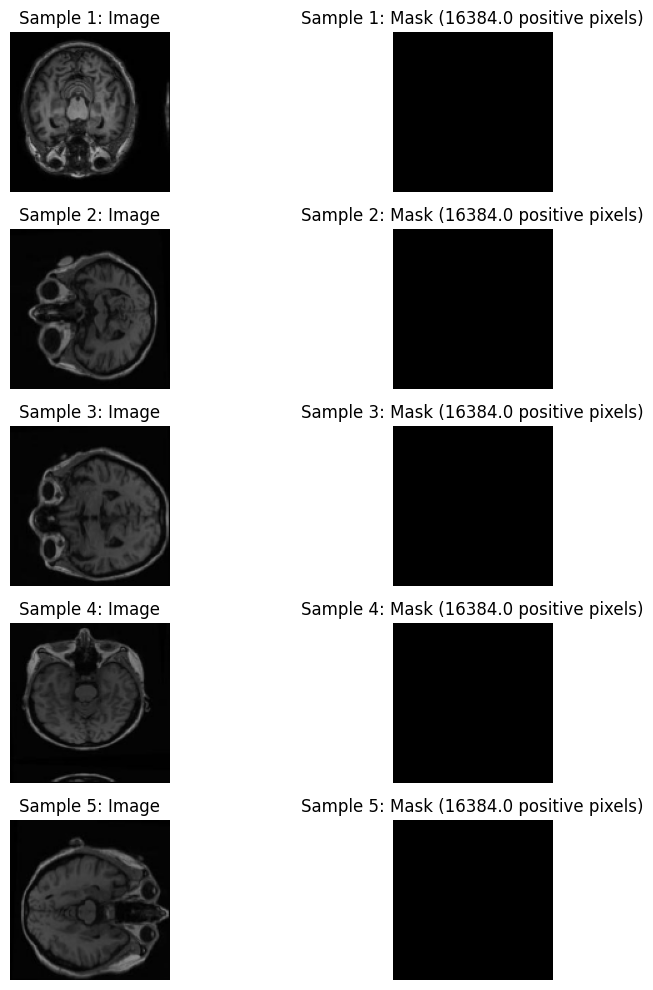

Displayed 5 sample image-mask pairs.


In [4]:
# Cell 4: Visualize Dataset Samples
# Purpose: Display sample image-mask pairs to verify data loading.
import matplotlib.pyplot as plt

def visualize_samples(X, Y, num_samples=5):
    if len(X) < num_samples:
        print(f"Warning: Only {len(X)} samples available.")
        num_samples = len(X)

    plt.figure(figsize=(10, num_samples * 2))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title(f"Sample {i+1}: Mask ({np.sum(Y[i])} positive pixels)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(X_train, Y_train, num_samples=5)
print("Displayed 5 sample image-mask pairs.")

In [5]:
# Cell 5: Define Montage Function
# Purpose: Create montages of images or masks.
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    if len(images) == 0:
        return None
    images = images[:n_rows * n_cols]
    h, w = images.shape[1:3]
    if images.ndim == 4 and images.shape[-1] == 1:
        images = images[..., 0]
    montage = np.zeros((h * n_rows, w * n_cols, images.shape[-1] if images.ndim > 3 else 1), dtype=np.float32)
    for i in range(min(len(images), n_rows * n_cols)):
        r, c = divmod(i, n_cols)
        img = images[i]
        montage[r*h:(r+1)*h, c*w:(c+1)*w] = img[..., np.newaxis] if img.ndim == 2 else img
    plt.figure(figsize=(n_cols*2, n_rows*2))
    plt.imshow(montage.squeeze(), cmap=cmap)
    plt.axis('off')
    return plt.gcf()

print("Montage function defined.")

Montage function defined.
